In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
root_path = os.path.realpath('../')
sys.path.append(root_path)
from utils import eval, choicemodel, plotting
from hebbcl.parameters import parser

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True


## Figure 1: Experiment design and baselines

In [ ]:
%matplotlib inline
plotting.plot_basicstats(models=["baseline_interleaved_new_select", "baseline_blocked_new_select"], n_epochs=200)

In [ ]:
plotting.plot_mds(filename_embedding="mds_embedding_baseline_int_new",filename_runs= "baseline_interleaved_new_select", thetas=(40,0,10), layer="all_y_hidden", n_runs=50, resultsdir="../results/")


In [ ]:

plotting.plot_mds(filename_embedding="mds_embedding_baseline_blocked_new", filename_runs = "baseline_blocked_new_select", thetas=(-10,-10, -70), layer="all_y_hidden", n_runs=50, resultsdir="../results/")



## Figure 2: The cost of interleaving

In [ ]:
# choice matrix models

%matplotlib inline
_,_,cmats = eval.gen_behav_models()

f,ax = plt.subplots(2,2, figsize=(2,2),dpi=300)
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(np.flipud(cmats[i,j,:,:]))
        if j<1:
            ax[i,j].set(xlabel='rel',ylabel='irrel')
        else:
            ax[i,j].set(xlabel='irrel',ylabel='rel')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])


In [ ]:
# accuracy (sluggishness)
% matplotlib inline

plotting.plot_sluggish_results(filename="sluggish_baseline_int_select_sv")

## Figure 3: continual learning with manual gating

In [ ]:
plotting.plot_basicstats(models = "gated_blocked_new_select_cent")

In [ ]:
plotting.plot_mds(filename_embedding="mds_embedding_gated_blocked_new",filename_runs= "gated_blocked_new_select_cent", thetas=(-20,-20,-150), layer="all_y_hidden", n_runs=50, resultsdir="../results/")


## Figure 4: Hebbian learning of context weights (Oja on all hidden units)

In [ ]:
# todo load individual runs and kick out the ones that did not converge, re-run those
import pickle
accs = {}
for r in range(0,50):
    with open(f"../checkpoints/blobs_asha_200episodes_blocked_ojaall_1ctx_4/run_{r}/results.pkl","rb") as f:
        data = pickle.load(f)
    accs[r] = data["acc_1st"][-1]
badruns = []
for k,v in accs.items():
    if v < 0.95:
        print(f"{k}: {v:.2}")
        badruns.append(k)

In [ ]:
from hebbcl.tuner import load_tuner_results
import argparse
# 1. load config
filepath = "../results/"
datapath = "../datasets/"
whichtrial = 0
filename = "blobs_asha_200episodes_interleaved_ojaall_1ctx"
results = load_tuner_results(filename, filepath)
args = argparse.Namespace(**results["config"])
df = results["df"].sort_values("mean_loss")
params = ["config.lrate_sgd", "config.lrate_hebb", "config.ctx_scaling"]
hps = dict(df[[c for c in df.columns if c in params]].iloc[whichtrial, :])
for k, v in hps.items():
    setattr(args, k.split(".")[1], v)

args.save_dir = filename if whichtrial == 0 else filename + "_" + str(whichtrial)


# n_jobs = 6
# from hebbcl.tuner import execute_run
# from joblib import Parallel, delayed 
# import numpy as np
# seeds = np.random.randint(np.iinfo(np.int32).max, size=args.n_runs)
# Parallel(n_jobs=n_jobs, verbose=10)(
#     delayed(execute_run)(
#         i_run,
#         np.random.randint(np.iinfo(np.int32).max),
#         args,
#         dataset_id="blobs",
#         filepath=datapath,
#         filesuffix="_ds18",
#     )
#     for i_run in badruns
# )
dict(sorted(vars(args).items()))

In [ ]:
plotting.biplot_dataset(ds="blobs",ctx_scaling=6)

In [ ]:
plotting.plot_oja(n_hidden=1, ds="blobs")

In [ ]:
plotting.plot_oja(n_hidden=1, ds="trees")

In [ ]:
plotting.plot_basicstats(models=["blobs_asha_200episodes_blocked_ojaall_1ctx_4"])

In [ ]:
plotting.plot_mds(filename_embedding = "mds_blobs_asha_200episodes_blocked_ojaall_1ctx_4", 
filename_runs="blobs_asha_200episodes_blocked_ojaall_1ctx_4", thetas = (70,-15,-10),axlims=8.5)


## Figure 5: Modelling human learning with Oja + EMA (8 episodes)

### HP Grid Search

In [ ]:
plotting.plot_gridsearch_modelvalidation(model_int="blobs_revision_8episodes_sluggish_interleaved_oja_sv", model_blocked="blobs_revision_8episodes_sluggish_blocked_oja_sv",sluggish_vals = np.linspace(0.05, 1, 30))

In [ ]:
plotting.plot_gridsearch_singlesubjects(model_int="blobs_revision_8episodes_sluggish_interleaved_oja_sv", model_blocked="blobs_revision_8episodes_sluggish_blocked_oja_sv",sluggish_vals = np.linspace(0.05, 1, 30))

In [ ]:
plotting.plot_gridsearch_group(model_int="blobs_revision_8episodes_sluggish_interleaved_oja_sv", model_blocked="blobs_revision_8episodes_sluggish_blocked_oja_sv",sluggish_vals = np.linspace(0.05, 1, 30))

### Learning Curves

In [ ]:
import pickle
with open("../checkpoints/blobs_revision_8episodes_blocked_oja/run_12/results.pkl", "rb") as f:
    results = pickle.load(f)
results["acc_1st"][:4], results["acc_2nd"][4:]

### Accuracy

In [ ]:
plotting.plot_modelcomparison_accuracy(
    baseline_models=["blobs_revision_8episodes_interleaved_vanilla","blobs_revision_8episodes_blocked_vanilla"],
    hebb_models=["blobs_revision_8episodes_sluggish_interleaved_oja_sv","blobs_revision_8episodes_blocked_oja"],
    sluggish_vals=np.round(np.linspace(0.05,1,30),2),sluggishness=0.51,slope_blocked=12,slope_int=12)

### Sigmoids

In [ ]:
betas = plotting.plot_modelcomparison_sigmoids(
    baseline_models=["blobs_revision_8episodes_interleaved_vanilla","blobs_revision_8episodes_blocked_vanilla"],
    hebb_models=["blobs_revision_8episodes_sluggish_interleaved_oja_sv","blobs_revision_8episodes_blocked_oja"],
    sluggish_vals=np.round(np.linspace(0.05,1,30),2),sluggishness=0.51,slope_blocked=12,slope_int=12)

In [ ]:
plotting.plot_modelcomparison_betas(betas)

### Choice Matrices

In [ ]:
cmats = plotting.plot_modelcomparison_choicemats(
    baseline_models=["blobs_revision_8episodes_interleaved_vanilla","blobs_revision_8episodes_blocked_vanilla"],
    hebb_models=["blobs_revision_8episodes_sluggish_interleaved_oja_sv","blobs_revision_8episodes_blocked_oja"],
    sluggish_vals=np.round(np.linspace(0.05,1,30),2),sluggishness=0.51,slope_blocked=12,slope_int=12)

### Psychophysical Model

In [ ]:
plotting.plot_modelcomparison_choicemodel(
    baseline_models=["blobs_revision_8episodes_interleaved_vanilla","blobs_revision_8episodes_blocked_vanilla"],
    hebb_models=["blobs_revision_8episodes_sluggish_interleaved_oja_sv","blobs_revision_8episodes_blocked_oja"],
    sluggish_vals=np.round(np.linspace(0.05,1,30),2),sluggishness=0.51,slope_blocked=12,slope_int=12)

### Congruency Effect

In [ ]:
plotting.plot_modelcomparison_congruency(cmats)

## Figure 6: Neural predictions

### Hidden Layer RSA
Fit grid, orthogonal and diagonal model to data.  
Prediction: Orthogonal best in blocked, diagonal best in interleaved group

In [ ]:
np.round(np.linspace(0.05,1,30),2)

In [ ]:
betas = plotting.plot_modelcomparison_hiddenlayerRSA(    
    hebb_models=["blobs_revision_8episodes_sluggish_interleaved_oja_sv","blobs_revision_8episodes_blocked_oja"],
    sluggish_vals=np.round(np.linspace(0.05,1,30),2))

### Task Selectivity (%)

In [ ]:
plotting.plot_modelcomparison_taskselectivity(    
    hebb_models=["blobs_revision_8episodes_sluggish_interleaved_oja_sv","blobs_revision_8episodes_blocked_oja"],
    sluggish_vals=np.round(np.linspace(0.05,1,30),2),sluggishness=0.51)

### Receptive fields of hidden layer weights

In [ ]:
# blocked: show that task selective aligned with rel dims, task agnostic aligned with diagonal
# interleaved: ditto

### Ablation study

In [ ]:
# blocked: show that removing task agnostic impairs performance less than removing task selective units 
# interleaved: ditto

### Readout Magnitude

In [ ]:
plotting.plot_modelcomparison_readout(    
    hebb_models=["blobs_revision_8episodes_sluggish_interleaved_oja_sv","blobs_revision_8episodes_blocked_oja"],
    sluggish_vals=np.round(np.linspace(0.05,1,30),2),sluggishness=0.51)

## Figure S2: Replication with fewer trials

In [ ]:
%matplotlib inline
plotting.plot_basicstats(models=["blobs_revision_8episodes_interleaved_oja", "blobs_revision_8episodes_blocked_oja"], n_epochs=8)



In [ ]:
plotting.plot_mds(
    filename_embedding="mds_embeddingblobs_revision_8episodes_interleaved_oja",
    filename_runs= "blobs_revision_8episodes_interleaved_oja", thetas=(105,-50,0), 
    layer="all_y_hidden", n_runs=50, resultsdir="../results/")



In [ ]:

plotting.plot_mds(
    filename_embedding="mds_embedding_blobs_revision_8episodes_blocked_oja", 
    filename_runs = "blobs_revision_8episodes_blocked_oja", 
    thetas=(10,40,-70), layer="all_y_hidden", n_runs=50, resultsdir="../results/",axlims=7)


## Figure S1: Impact of training duration


In [ ]:
# todo
neps = 375
%matplotlib qt
plotting.plot_basicstats(models=[f"blobs_revision_{neps}episodes_blocked_oja"], n_epochs=neps)

## Figure S2: Replication of key findings with RGB inputs
1. task design
2. baseline model (fig 1 main but with baseline trees)
3. hebb model (fig 4 main but with hebb model)

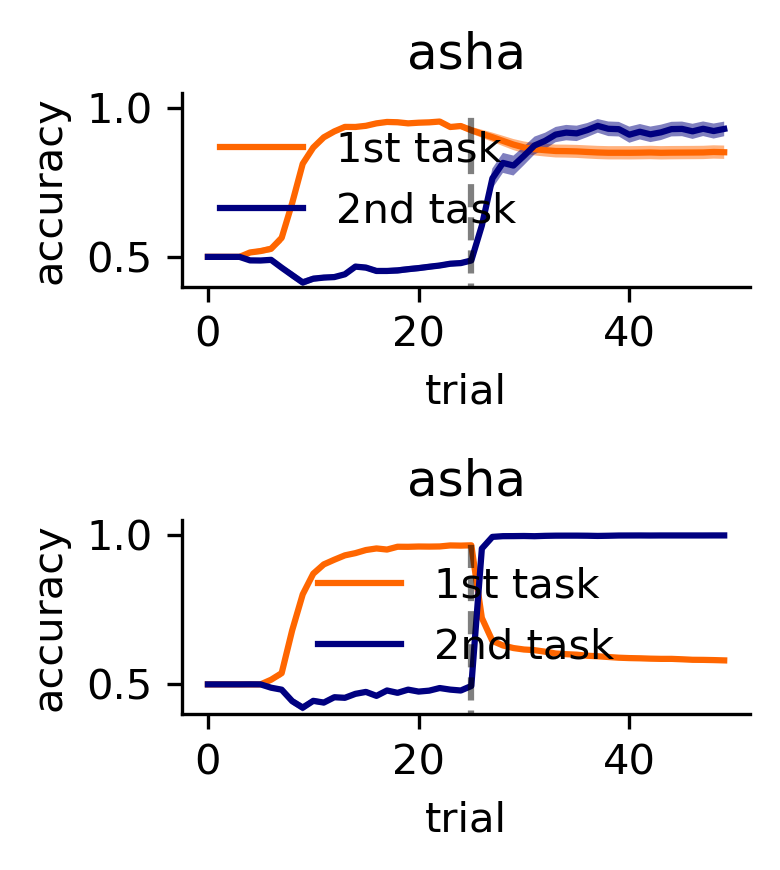

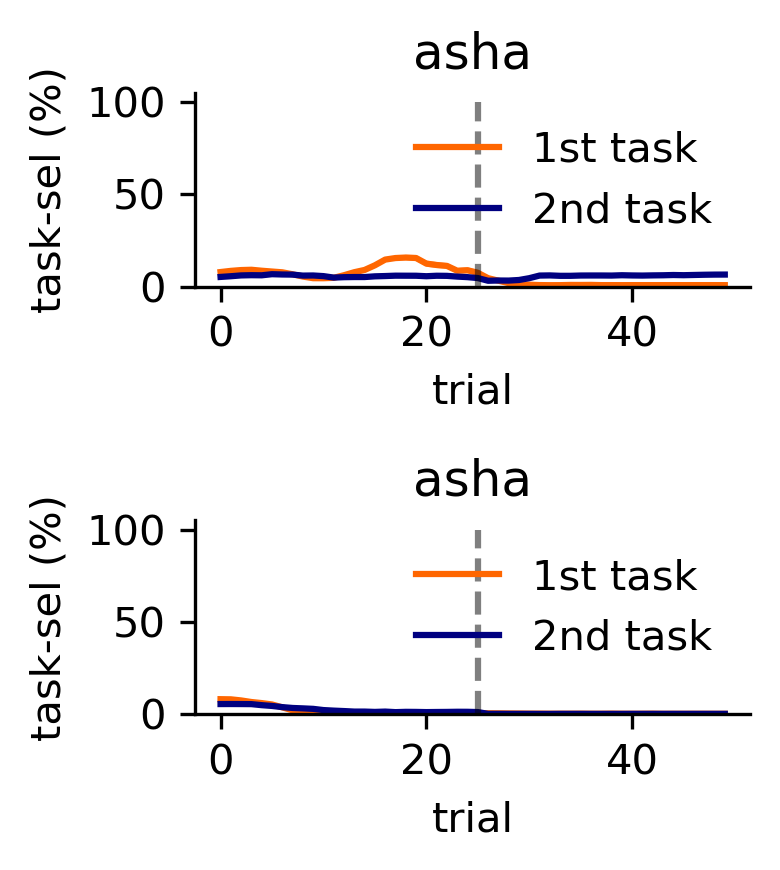

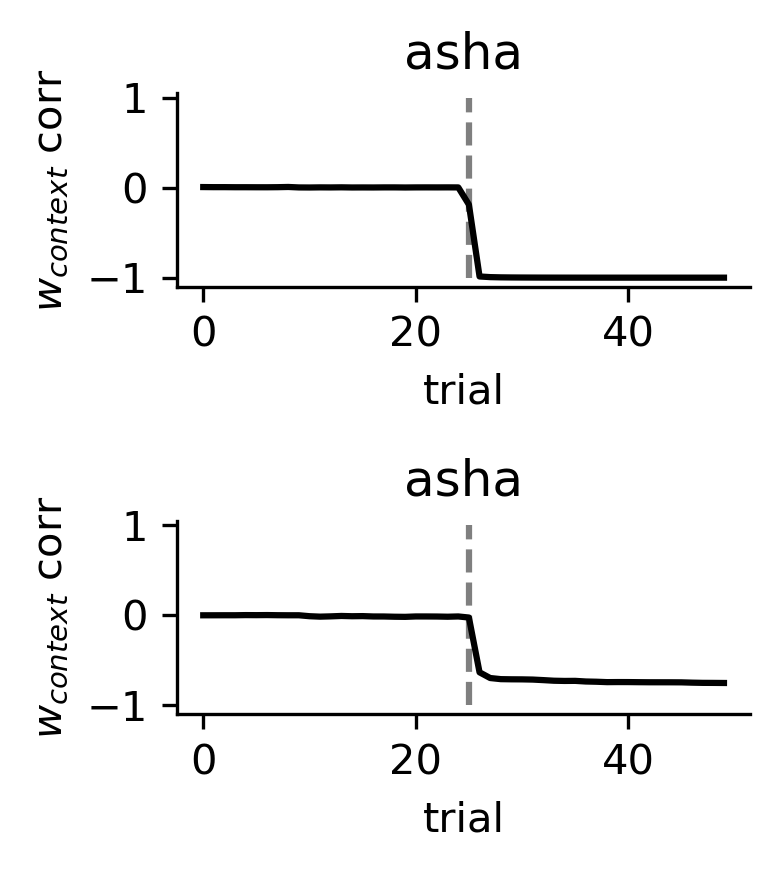

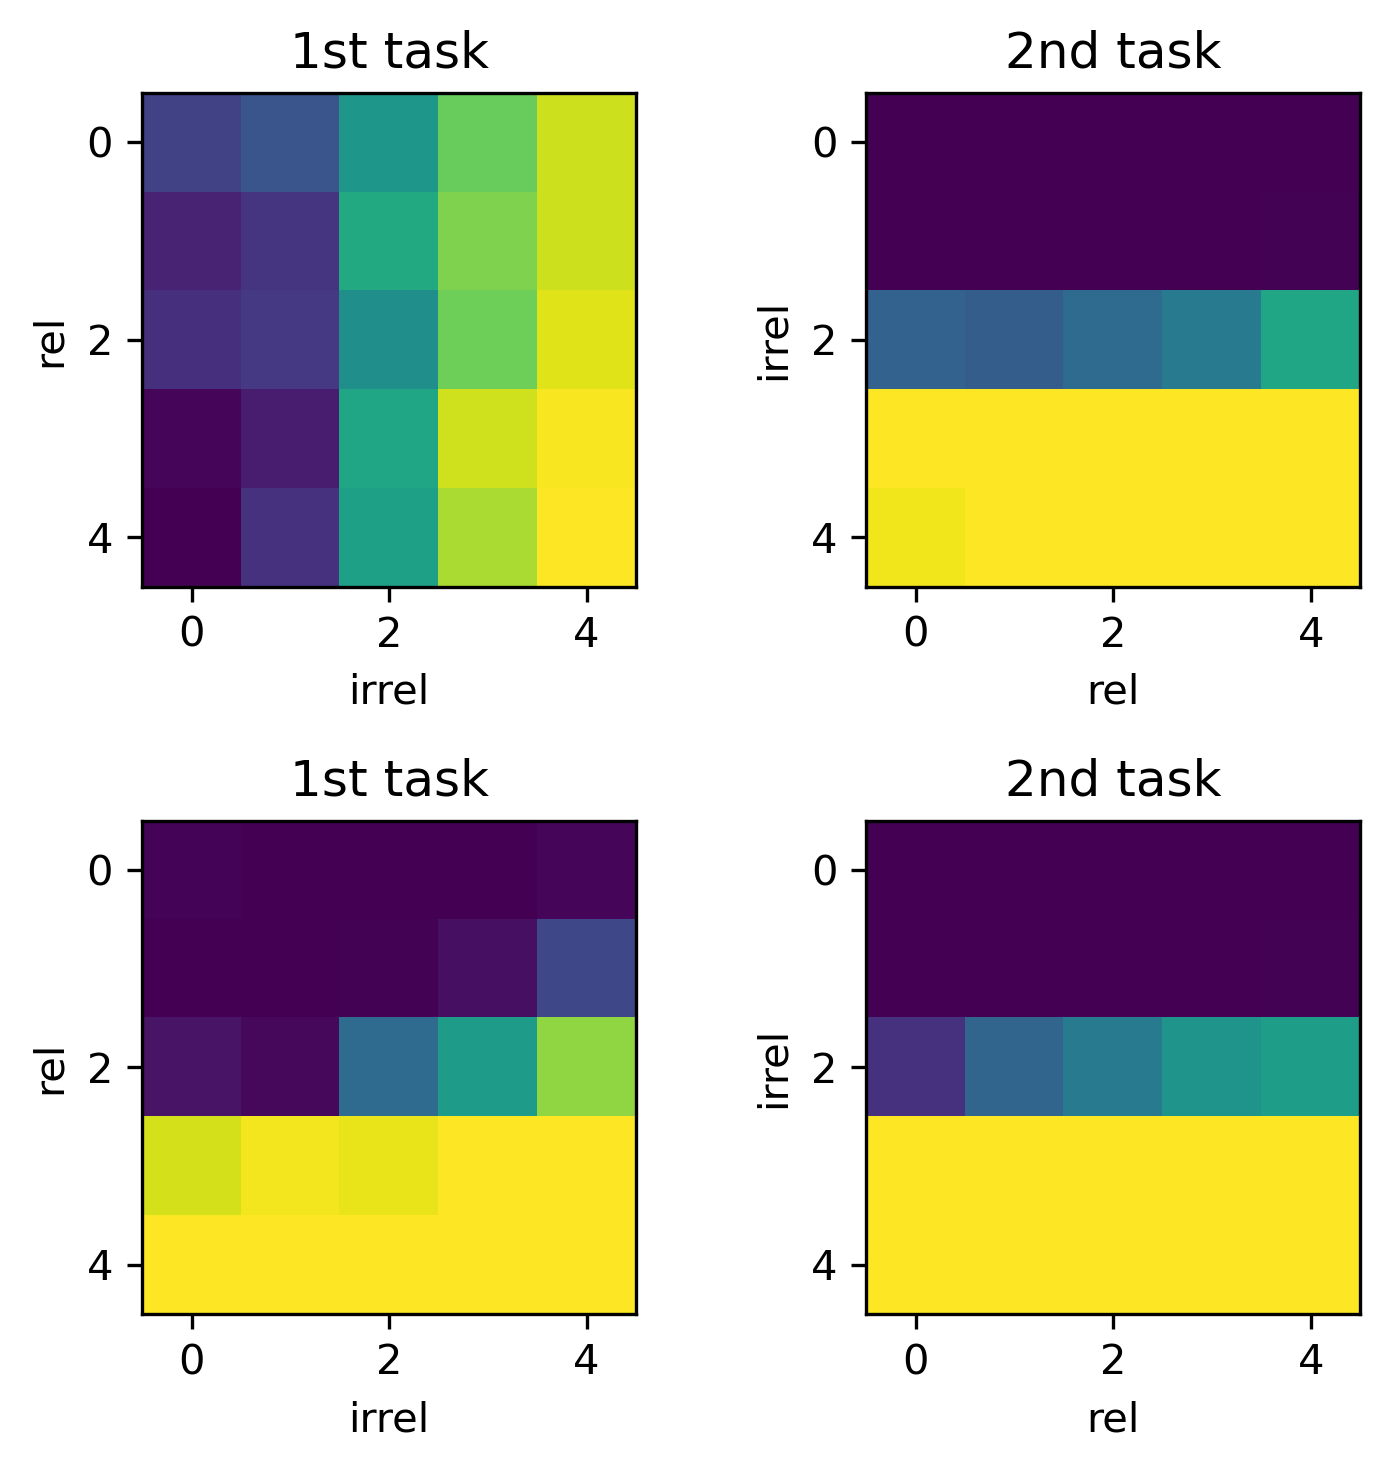

In [37]:
%matplotlib inline
plotting.plot_basicstats(models=["trees_asha_interleaved_ojactx_1ctx", "trees_asha_blocked_ojactx_1ctx"], n_epochs=50,fixtreesbug=True,n_runs=50)



In [ ]:
plotting.plot_mds(
    filename_embedding="mds_embedding_trees_asha_interleaved_ojactx_1ctx_yhidden",
    filename_runs= "trees_asha_interleaved_ojactx_1ctx", thetas=(125,0,45), 
    layer="all_y_hidden", n_runs=50, resultsdir="../results/",fixtreesbug=True,axlims=8)

In [ ]:
plotting.plot_mds(
    filename_embedding="mds_embedding_trees_asha_interleaved_ojactx_1ctx_yhidden2",
    filename_runs= "trees_asha_interleaved_ojactx_1ctx", thetas=(-80,0,90), 
    n_runs=50, resultsdir="../results/",fixtreesbug=True,axlims=8,layer="all_y_hidden2")

In [ ]:
plotting.plot_mds(
    filename_embedding="mds_embedding_trees_asha_blocked_ojactx_1ctx_yhidden",
    filename_runs= "trees_asha_blocked_ojactx_1ctx", thetas=(65,25,-270), 
    layer="all_y_hidden", n_runs=50, resultsdir="../results/",fixtreesbug=True,axlims=10)

In [ ]:
plotting.plot_mds(
    filename_embedding="mds_embedding_trees_asha_blocked_ojactx_1ctx_yhidden2",
    filename_runs= "trees_asha_blocked_ojactx_1ctx", thetas=(0,40,20), 
    layer="all_y_hidden2", n_runs=50, resultsdir="../results/",fixtreesbug=True,axlims=15)

In [ ]:
%matplotlib inline
plotting.plot_basicstats(models=["trees_asha_interleaved_ojaall_1ctx", "trees_asha_blocked_ojaall_1ctx"], n_epochs=50,fixtreesbug=True,n_runs=50)

